<a href="https://colab.research.google.com/github/ojasrai17/Predicting-crop-types-using-ML/blob/main/ML_miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd

# Load the CSV file
file_path = '/content/soil_measures.csv'  # Update with your file path
soil_data = pd.read_csv(file_path)

# Display the first few rows and basic information to confirm it's loaded correctly
print("First few rows of the dataset:")
print(soil_data.head())
# Display basic information about the dataset
print("\nDataset Information:")
soil_data.info()



First few rows of the dataset:
    N   P   K        ph  crop
0  90  42  43  6.502985  rice
1  85  58  41  7.038096  rice
2  60  55  44  7.840207  rice
3  74  35  40  6.980401  rice
4  78  42  42  7.628473  rice

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


In [ ]:
# Check for missing values
print("Missing values per column:")
print(soil_data.isnull().sum())

# Check for duplicates
duplicates = soil_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Drop duplicates if any
soil_data = soil_data.drop_duplicates()

# Check for outliers (using IQR or Z-score methods if required) for each numeric column
import numpy as np

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    filter = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)
    return df.loc[filter]

# Apply outlier removal for all numeric columns (N, P, K, ph)
for col in ['N', 'P', 'K', 'ph']:
    soil_data = remove_outliers(soil_data, col)


Missing values per column:
N       0
P       0
K       0
ph      0
crop    0
dtype: int64

Number of duplicate rows: 0


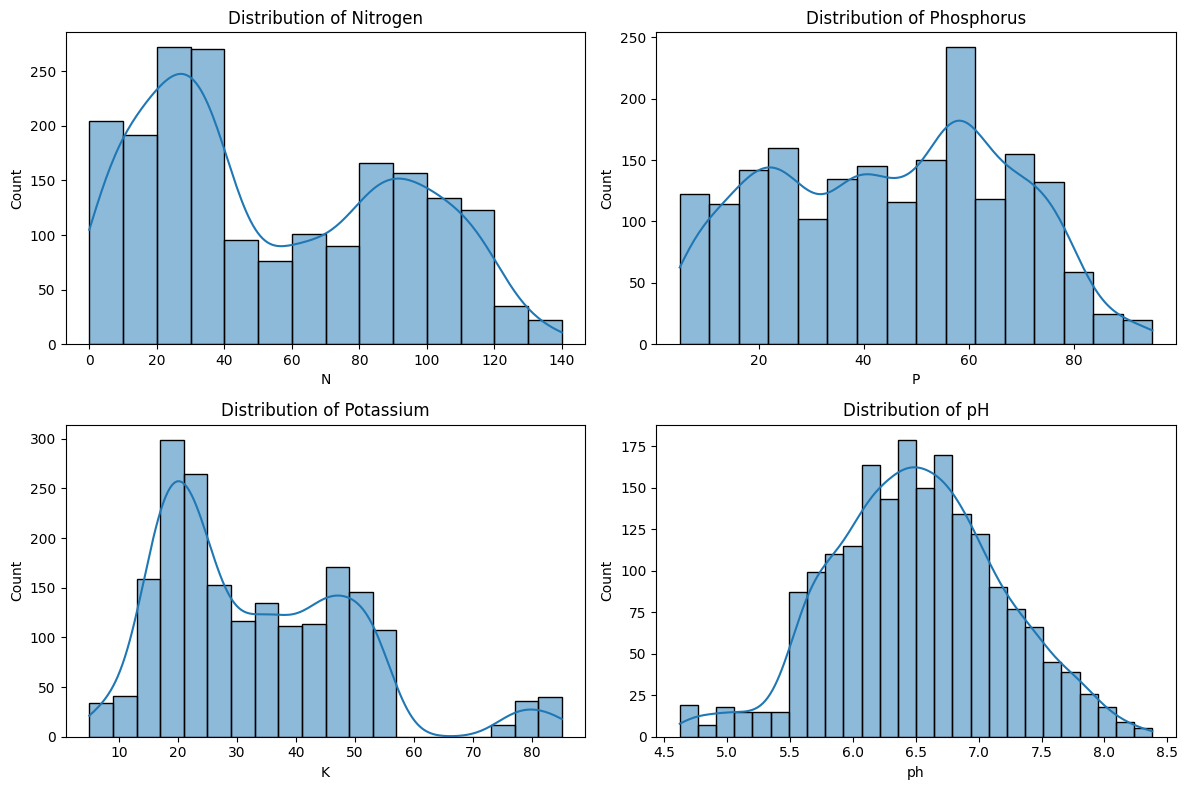

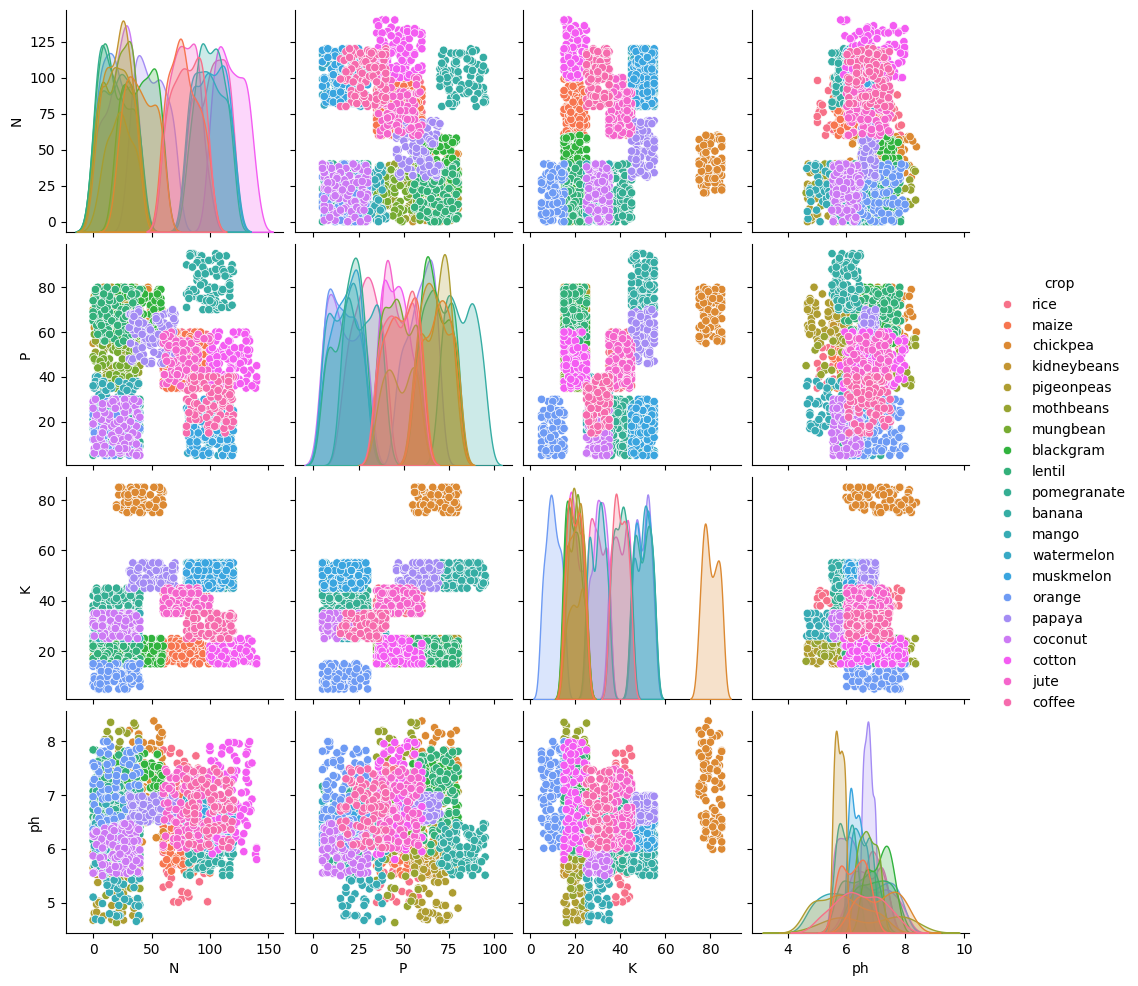

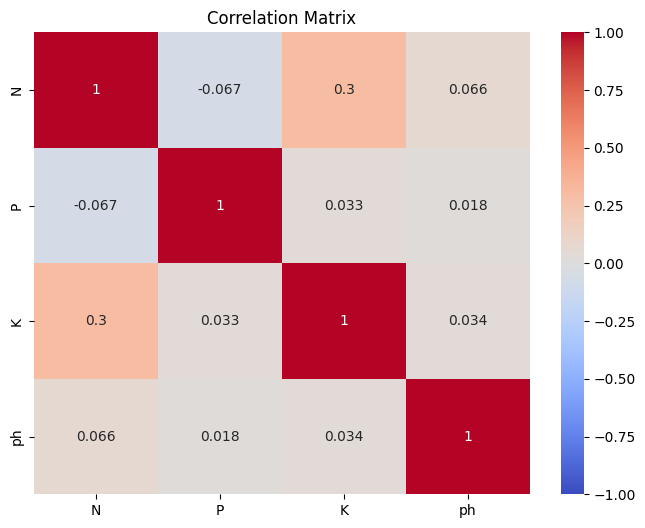

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of each nutrient level and pH
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(soil_data['N'], kde=True, ax=axes[0, 0]).set_title('Distribution of Nitrogen')
sns.histplot(soil_data['P'], kde=True, ax=axes[0, 1]).set_title('Distribution of Phosphorus')
sns.histplot(soil_data['K'], kde=True, ax=axes[1, 0]).set_title('Distribution of Potassium')
sns.histplot(soil_data['ph'], kde=True, ax=axes[1, 1]).set_title('Distribution of pH')
plt.tight_layout()
plt.show()

# Pair plot to visualize relationships between features and the crop type
sns.pairplot(soil_data, hue='crop')
plt.show()

# Correlation matrix for numerical columns only
plt.figure(figsize=(8, 6))
sns.heatmap(soil_data[['N', 'P', 'K', 'ph']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Separate features and target variable
X = soil_data.drop(columns=['crop'])
y = soil_data['crop']

# One-hot encode the 'crop' column
soil_data_encoded = pd.get_dummies(soil_data, columns=['crop'], drop_first=True)

# Define X and y after encoding
X = soil_data_encoded.drop(columns=[col for col in soil_data_encoded.columns if col.startswith('crop_')])
y = soil_data_encoded[[col for col in soil_data_encoded.columns if col.startswith('crop_')]]

# Verify the updated feature set and target variables
print("Features (X):")
print(X.head())
print("\nTarget (y):")
print(y.head())


Features (X):
    N   P   K        ph
0  90  42  43  6.502985
1  85  58  41  7.038096
2  60  55  44  7.840207
3  74  35  40  6.980401
4  78  42  42  7.628473

Target (y):
   crop_blackgram  crop_chickpea  crop_coconut  crop_coffee  crop_cotton  \
0           False          False         False        False        False   
1           False          False         False        False        False   
2           False          False         False        False        False   
3           False          False         False        False        False   
4           False          False         False        False        False   

   crop_jute  crop_kidneybeans  crop_lentil  crop_maize  crop_mango  \
0      False             False        False       False       False   
1      False             False        False       False       False   
2      False             False        False       False       False   
3      False             False        False       False       False   
4      False     

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import numpy as np

# Define X and y for training/testing
X = soil_data_encoded.drop(columns=[col for col in soil_data_encoded.columns if col.startswith('crop_')])
y = soil_data['crop']  # original target variable before encoding

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the three models
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)

# Cross-validation for each model
models = {
    'Logistic Regression': logistic_model,
    'Decision Tree': decision_tree_model,
    'Random Forest': random_forest_model
}

for model_name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{model_name} Mean CV Score: {np.mean(cv_scores):.3f}")

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # or 'macro' based on your preference
    f1 = f1_score(y_test, y_pred, average='weighted')  # or 'macro'
    recall = recall_score(y_test, y_pred, average='weighted')  # or 'macro'
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print the results
    print(f"{model_name} Accuracy: {accuracy:.3f}")
    print(f"{model_name} Precision: {precision:.3f}")
    print(f"{model_name} F1 Score: {f1:.3f}")
    print(f"{model_name} Recall: {recall:.3f}")
    print(f"{model_name} Confusion Matrix:\n{conf_matrix}\n")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression Mean CV Score: 0.693


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.696
Logistic Regression Precision: 0.684
Logistic Regression F1 Score: 0.679
Logistic Regression Recall: 0.696
Logistic Regression Confusion Matrix:
[[24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  8  0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0 21  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  8  0]
 [ 0  2  0  0  0  0  0  9  2  0  0  0  0  0  0  0 13  0  0  0]
 [ 0  2  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0 16  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0 12  0  0  0  0  0  0  1  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  3  0  0  1 17  0  0  0  1  0  0  0]


In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5)
grid_search_dt.fit(X_train, y_train)
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)
best_dt = grid_search_dt.best_estimator_

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_


Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


Accuracy Score: 0.8350515463917526

Classification Report:
               precision    recall  f1-score   support

      banana       1.00      1.00      1.00        24
   blackgram       0.64      0.93      0.76        15
    chickpea       1.00      1.00      1.00        19
     coconut       0.96      1.00      0.98        23
      coffee       1.00      0.77      0.87        22
      cotton       0.82      1.00      0.90        14
        jute       0.48      0.89      0.63        18
 kidneybeans       0.84      1.00      0.91        26
      lentil       0.53      0.73      0.62        11
       maize       0.89      0.94      0.92        18
       mango       1.00      0.93      0.97        15
   mothbeans       0.91      0.71      0.80        14
    mungbean       0.88      0.92      0.90        24
   muskmelon       0.65      0.74      0.69        23
      orange       1.00      1.00      1.00        24
      papaya       1.00      1.00      1.00        24
  pigeonpeas       1.

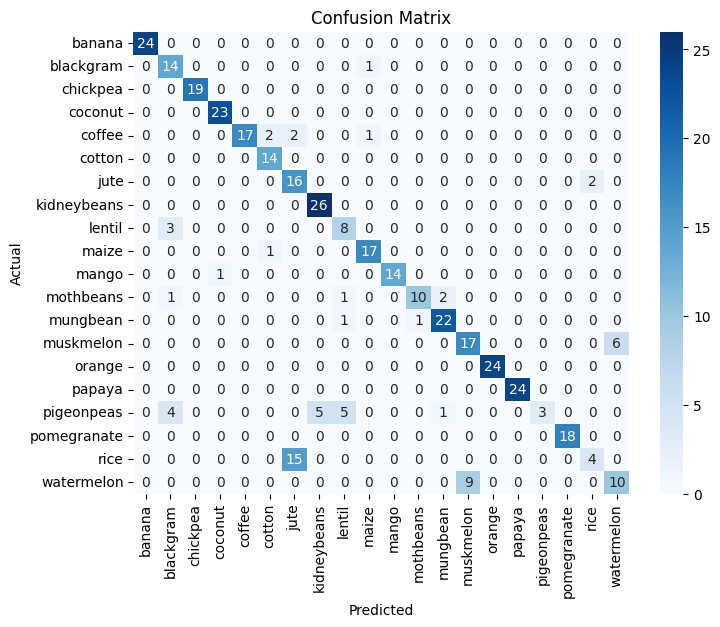

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use best model from tuning (e.g., Random Forest here)
best_model = best_rf  # or use best_dt

# Predictions and evaluation
y_pred = best_model.predict(X_test)

# Print evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Get unique class labels from the target variable
class_labels = np.unique(y)

# Confusion Matrix Visualization with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


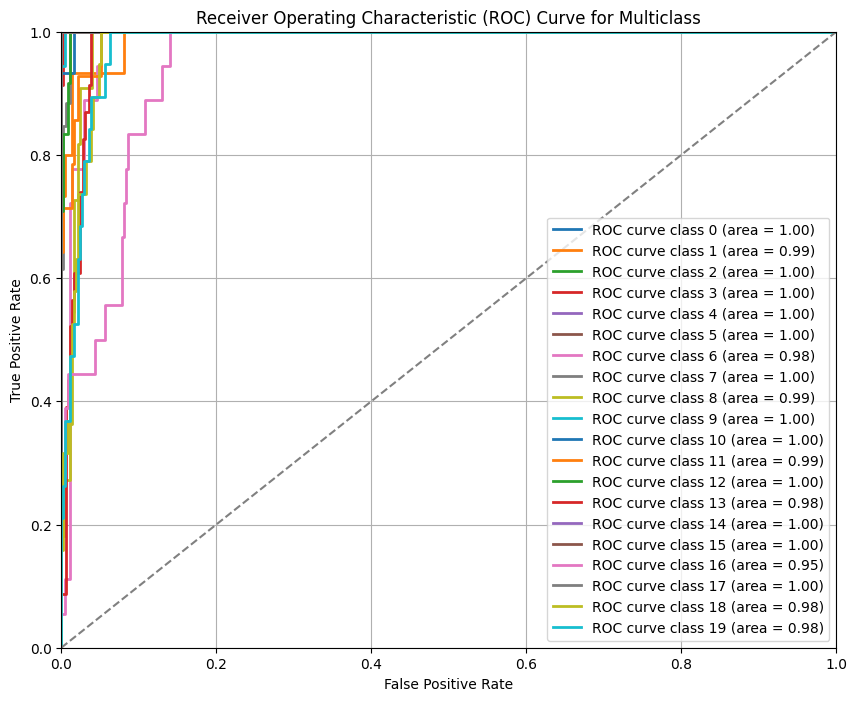

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming y_test contains labels for multiclass (e.g., [0, 1, 2])
# Binarize the output for multiclass
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Get the probabilities for each class
y_prob = best_model.predict_proba(X_test)

# Create a figure
plt.figure(figsize=(10, 8))

# Calculate ROC curve and ROC AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve class {0} (area = {1:0.2f})'.format(i, roc_auc))

# Plotting the random chance line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.grid()
plt.show()

